In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:

plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.serif'] = ['Times New Roman']


In [14]:
df_mac_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-12-22/big-mac.csv"
)
# A list of country/zones that are going to be highlighted
HIGHLIGHTS = ["EUZ", "CHE", "DNK", "SWE", "BRA", "ARG", "GBR", "USA"]

In [15]:
# Extract year
df_mac_raw["year"] = pd.DatetimeIndex(df_mac_raw["date"]).year

# Subset variables
df_mac_raw = df_mac_raw[["date", "year", "iso_a3", "currency_code", "name", "dollar_price"]]

In [16]:
# If there is more than one record per year/country, use the mean
df_mac = df_mac_raw.groupby(["iso_a3", "name", "year"]).agg(
    price = ("dollar_price", "mean")
).reset_index()

# Keep countries/regions with records for the last 21 years  
# (from 2000 to 2020 inclusive)
group_sizes = df_mac.groupby("iso_a3").size()
keep = (group_sizes[group_sizes == 21]).index.tolist()
df_mac = df_mac[df_mac["iso_a3"].isin(keep)]

# Keep countries that have a record for 2008, the index year.
countries = df_mac[df_mac["year"] == 2008]["iso_a3"].tolist()
df_mac_indexed_2008 = df_mac[df_mac["iso_a3"].isin(countries)]
df_mac_indexed_2008["ref_year"] = 2008

In [17]:
# For each country/region, obtain the price for 2008
df_price_index = df_mac_indexed_2008.groupby("iso_a3").apply(
   lambda x: x.iloc[np.where(x["year"] == 2008)]
).reset_index(drop=True)

# Rename this price to 'price_index'
df_price_index.rename(columns={"price": "price_index"}, inplace=True)

# Keep only 'iso_a3' and 'price_index' in this auxiliary table
df_price_index = df_price_index[["iso_a3", "price_index"]]

# Merge the index price
df_mac_indexed_2008 = pd.merge(df_mac_indexed_2008, df_price_index, on = "iso_a3")

# Compute relative price
df_mac_indexed_2008["price_rel"] = df_mac_indexed_2008["price"] - df_mac_indexed_2008["price_index"]

# Create 'group' to determine which ones are highlighted
df_mac_indexed_2008["group"] = np.where(
    df_mac_indexed_2008["iso_a3"].isin(HIGHLIGHTS),
    df_mac_indexed_2008["iso_a3"],
    "other"
)

# Make 'group' categorical 
df_mac_indexed_2008["group"] = pd.Categorical(
    df_mac_indexed_2008["group"], 
    ordered=True,  
    categories=sorted(HIGHLIGHTS) + ["other"]
)

In [18]:
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade countries
COLOR_SCALE = [
    "#7F3C8D", # ARG
    "#11A579", # BRA
    "#3969AC", # CHE
    "#F2B701", # DNK
    "#E73F74", # EUZ
    "#80BA5A", # GBR
    "#E68310", # SWE
    GREY50     # USA
]

# Vertical lines every 5 years
VLINES = np.arange(2000, 2025, 5)

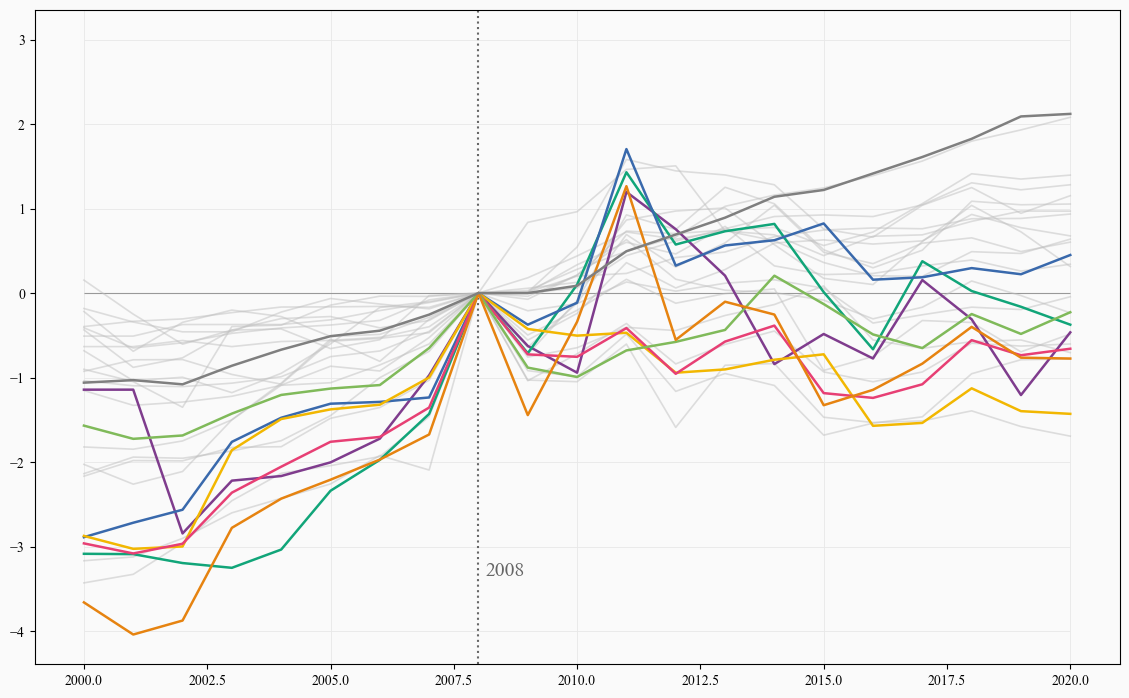

In [19]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(-4, 4), xmin=2000, xmax=2020, color=GREY91, lw=0.6)

# Darker horizontal line at y=0
ax.hlines(y=0, xmin=2000, xmax=2020, color=GREY60, lw=0.8)

# Vertical like at x = 2008
ax.axvline(2008, color=GREY40, ls="dotted")

# Annotations indicating the meaning of the vertical line
ax.text(2008.15, -3.35, "2008", fontname="Serif", 
        fontsize=14, fontweight=500, color=GREY40, ha="left")

# Add lines ------------------------------------------------------
# Create one data frame for the highlighted countries, and other
# for non-highlighted countries.
df_highlight = df_mac_indexed_2008[df_mac_indexed_2008["group"] != "other"]
df_others = df_mac_indexed_2008[df_mac_indexed_2008["group"] == "other"]

for group in df_others["iso_a3"].unique():
    data = df_others[df_others["iso_a3"] == group]
    ax.plot("year", "price_rel", c=GREY75, lw=1.2, alpha=0.5, data=data)

for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[df_highlight["iso_a3"] == group]
    color = COLOR_SCALE[idx]
    ax.plot("year", "price_rel", color=color, lw=1.8, data=data)

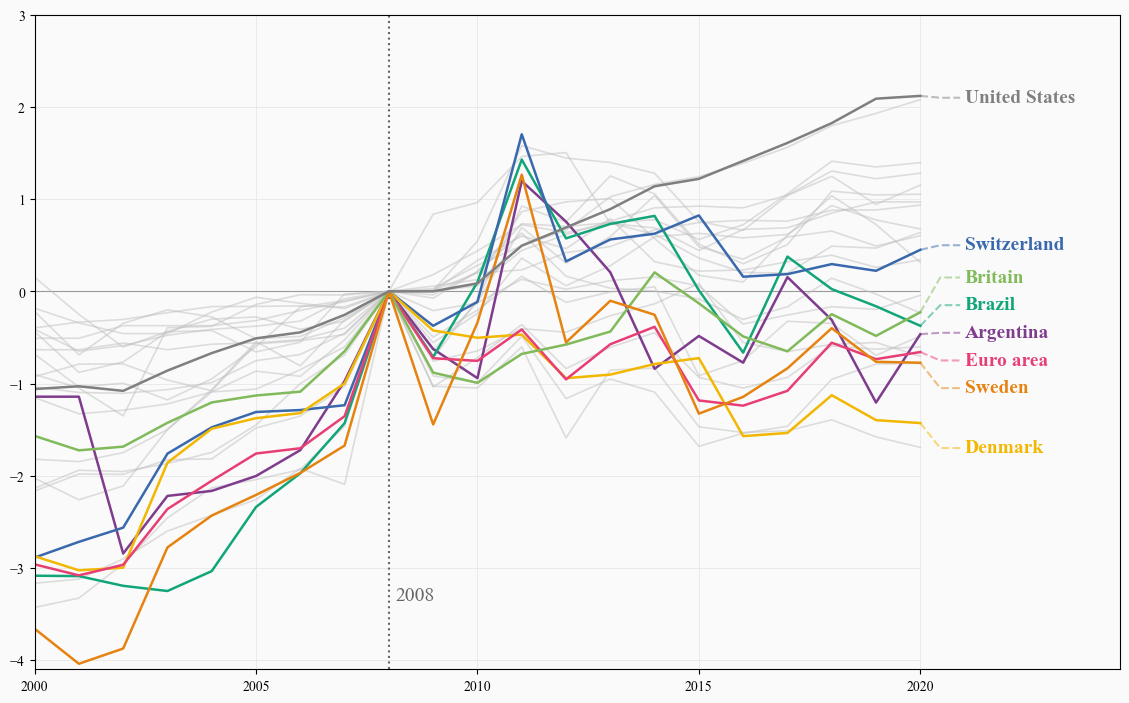

In [20]:
# First, adjust axes limits so annotations fit in the plot
ax.set_xlim(2000, 2024.5)
ax.set_ylim(-4.1, 3)

# Positions
LABEL_Y = [
    -0.45,  # ARG
    -0.15,  # BRA
    0.5,    # CHE
    -1.7,   # DNK
    -0.75,  # EUZ
    0.15,   # GBR
    -1.05,  # SWE
    2.1     # USA
]

x_start = 2020
x_end = 2021
PAD = 0.1

# Add labels for highlighted countries honly
for idx, group in enumerate(df_highlight["iso_a3"].unique()):
    data = df_highlight[(df_highlight["iso_a3"] == group) & (df_highlight["year"] == 2020)]
    color = COLOR_SCALE[idx]
    
    # Country name
    text = data["name"].values[0]
    
    # Vertical start of line
    y_start = data["price_rel"].values[0]
    # Vertical end of line
    y_end = LABEL_Y[idx]
    
    # Add line based on three points
    ax.plot(
        [x_start, (x_start + x_end - PAD) / 2 , x_end - PAD], 
        [y_start, y_end, y_end], 
        color=color, 
        alpha=0.5, 
        ls="dashed"
    )
    
    # Add country text
    ax.text(
        x_end, 
        y_end, 
        text, 
        color=color, 
        fontsize=14, 
        weight="bold", 
        fontfamily="Serif", 
        va="center"
    )
fig

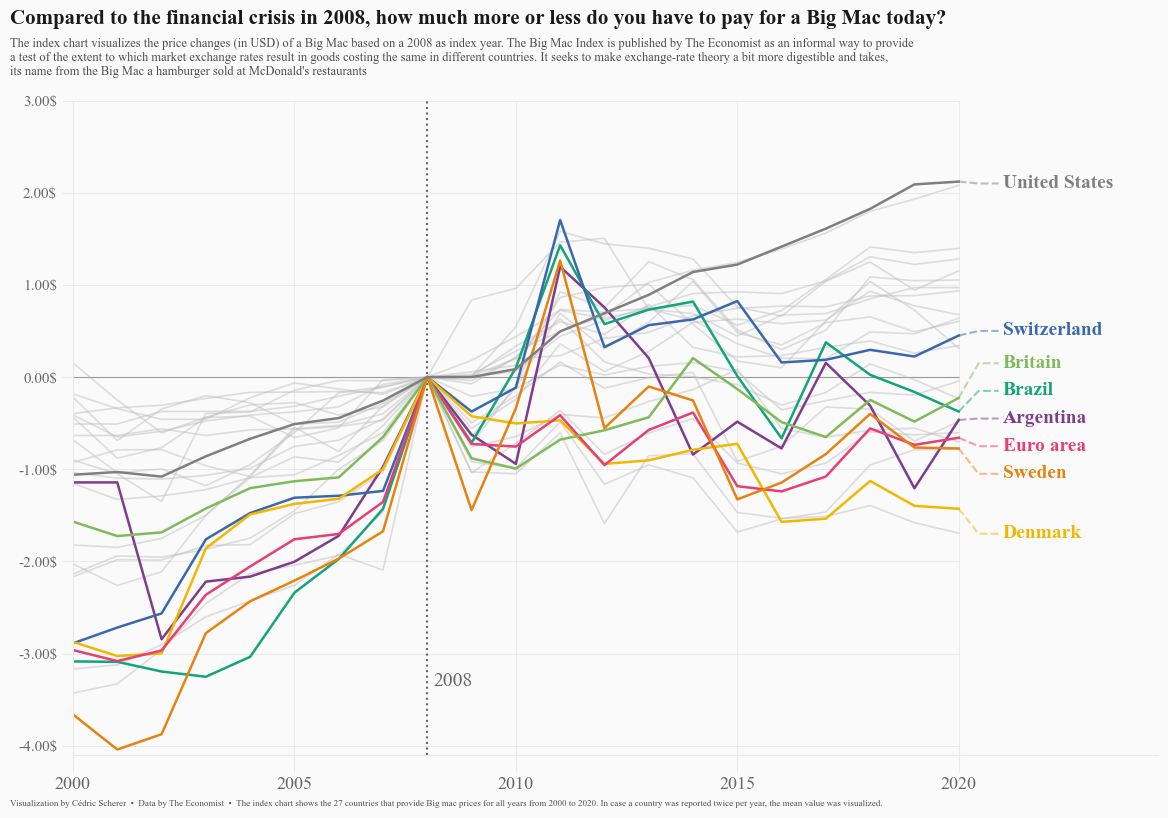

In [21]:
# Customize axes labels and ticks --------------------------------
ax.set_yticks([y for y in np.arange(-4, 4)])
ax.set_yticklabels(
    [f"{y}.00$" for y in np.arange(-4, 4)], 
    fontname="Serif", 
    fontsize=11,
    weight=500,
    color=GREY40
)

ax.set_xticks([x for x in np.arange(2000, 2025, 5)])
ax.set_xticklabels(
    [x for x in np.arange(2000, 2025, 5)], 
    fontname= "Serif", 
    fontsize=13,
    weight=500,
    color=GREY40
)

# Increase size and change color of axes ticks
ax.tick_params(axis="x", length=12, color=GREY91)
ax.tick_params(axis="y", length=8, color=GREY91)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Add titles, subtitles, and caption -----------------------------
# This uses `fig.text()` instead of regular titles to have full
# control of the text alignment.
subtitle = [
    "The index chart visualizes the price changes (in USD) of a Big Mac based on a 2008 as index year. The Big Mac Index is published by The Economist as an informal way to provide",
    "a test of the extent to which market exchange rates result in goods costing the same in different countries. It seeks to make exchange-rate theory a bit more digestible and takes,", 
    "its name from the Big Mac a hamburger sold at McDonald's restaurants", 
]

fig.text(
    0.08,
    0.97,
    "Compared to the financial crisis in 2008, how much more or less do you have to pay for a Big Mac today?",
    color=GREY10,
    fontsize=15,
    fontname="Serif",
    weight="bold"
)

fig.text(
    0.08,
    0.91,
    "\n".join(subtitle),
    ha="left",
    color=GREY30,
    fontname="Serif",
    fontsize=9,
)

fig.text(
    0.08, 
    0.05, 
    "Visualization by Cédric Scherer  •  Data by The Economist  •  The index chart shows the 27 countries that provide Big mac prices for all years from 2000 to 2020. In case a country was reported twice per year, the mean value was visualized.", 
    fontname="Serif", 
    fontsize=6.5, 
    color=GREY30, 
    ha="left"
)

fig

In [22]:
# Experimenting with https://python-graph-gallery.com/web-line-chart-small-multiple/

In [23]:

url = "https://raw.githubusercontent.com/holtzy/the-python-graph-gallery/master/static/data/dataConsumerConfidence.csv"
df = pd.read_csv(url)
# Reshape the DataFrame using pivot longer
df = df.melt(id_vars=['Time'], var_name='country', value_name='value')

# Convert to time format
df['Time'] = pd.to_datetime(df['Time'], format='%b-%Y')

# Remove rows with missing values (only one row)
df = df.dropna()


C:\Users\ajfon\AppData\Local\Temp\ipykernel_24592\1395426446.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_countries)


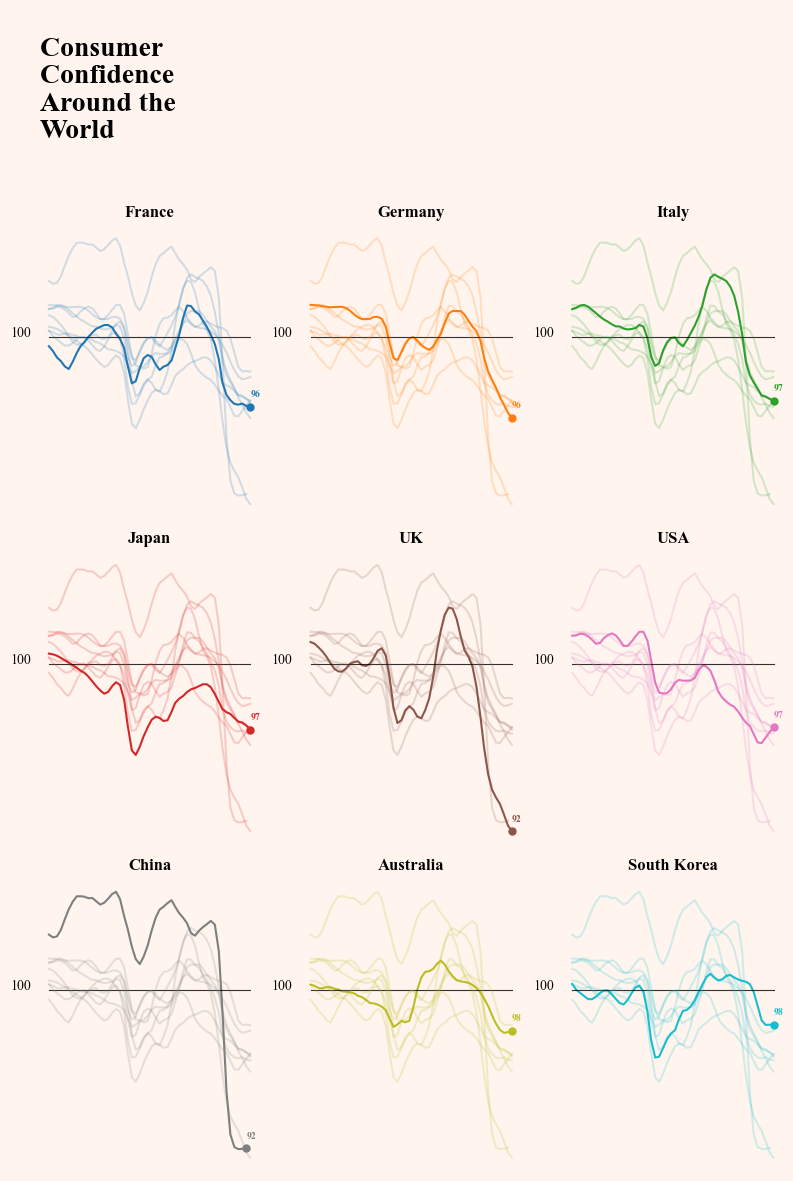

In [24]:
# Create a colormap with a color for each country
num_countries = len(df['country'].unique())
colors = plt.cm.get_cmap('tab10', num_countries)

# Init a 3x3 charts
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 12))

# Add a big title on top of the entire chart
fig.suptitle('\nConsumer \nConfidence \nAround the \nWorld\n\n', # Title ('\n' allows you to go to the line),
             fontsize=20,
             fontweight='bold', 
             x=0.05, # Shift the text to the left
             ha='left' # Align the text to the left
            )

# Plot each group in the subplots
for i, (group, ax) in enumerate(zip(df['country'].unique(), ax.flatten())):

    # Filter for the group
    filtered_df = df[df['country'] == group]
    x = filtered_df['Time']
    y = filtered_df['value']

    # Get last value (according to 'Time') for the group
    sorted_df = filtered_df.sort_values(by='Time')
    last_value = sorted_df.iloc[-1]['value']
    last_date = sorted_df.iloc[-1]['Time']

    # Set the background color for each subplot
    ax.set_facecolor('seashell')
    fig.set_facecolor('seashell')
    
    # Plot the line
    ax.plot(x, y, color=colors(i))
    
    # Add the final value
    ax.plot(last_date, # x-axis position
            last_value, # y-axis position
            marker='o', # Style of the point
            markersize=5, # Size of the point
            color=colors(i), # Color
           )
    
    # Add the text of the value
    ax.text(last_date,
             last_value*1.005, # slightly shift up
             f'{round(last_value)}', # round for more lisibility
             fontsize=7,
             color=colors(i), # color
             fontweight='bold',
           )

    # Add the 100 on the left
    ax.text(sorted_df.iloc[0]['Time'] - pd.Timedelta(days=300), # shift the position to the left
             100,
             '100',
             fontsize=10,
             color='black',)

    # Add line 
    sorted_df = df.sort_values(by='Time')
    start_x_position = sorted_df.iloc[0]['Time']
    end_x_position = sorted_df.iloc[-1]['Time']
    ax.plot([start_x_position, end_x_position], # x-axis position
            [100, 100], # y-axis position (constant position)
            color='black', # Color
            alpha=0.8, # Opacity
            linewidth=0.8, # width of the line
           )
    
    # Plot other groups with lighter colors (alpha argument)
    other_groups = df['country'].unique()[df['country'].unique() != group]
    for other_group in other_groups:

        # Filter observations that are not in the group
        other_y = df['value'][df['country'] == other_group]
        other_x = df['Time'][df['country'] == other_group]

        # Display the other observations with less opacity (alpha=0.2)
        ax.plot(other_x, other_y, color=colors(i), alpha=0.2)

    # Removes spines
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    
    # Add a bold title to each subplot
    ax.set_title(f'{group}', fontsize=12, fontweight='bold')
    
    # Remove axis labels
    ax.set_yticks([])
    ax.set_xticks([])

# Adjust layout and spacing
plt.tight_layout()

# Show the plot
plt.show()